In [1]:
!pip install numpyro
!pip install arviz
!pip install tensorflow
!pip install tensorflow-probability

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.2/927.2 kB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 129.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.7/241.7 kB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 110.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 50.5 MB/s eta 0:00:00


In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import pandas as pd
from sklearn.model_selection import train_test_split
import numpyro as npyro
from numpyro.infer import MixedHMC, MCMC
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
from numpyro.infer import MCMC, MixedHMC, HMC
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import AffineTransform
import matplotlib.pyplot as plt
tfd = tfp.distributions

In [3]:
jax.default_backend()

'gpu'

In [4]:
plt.style.use("ggplot")

In [5]:
def logistic(x):
    return 1/(1 + jnp.exp(-x))

In [6]:
# seed = 1234
# np.random.seed(seed)
# rng_key = jax.random.PRNGKey(seed)
# _, rng_key_split = jax.random.split(rng_key)

In [7]:
exp_seeds = []
with open("seeds.txt", "r") as fp:
    for line in fp.readlines():
        exp_seeds.append(int(line.strip()))

len(exp_seeds)

50

In [8]:
jax_exp_seeds = []
for seed in exp_seeds:
    jax_exp_seeds.append(jax.random.PRNGKey(seed))

In [9]:
def run_fs_logreg(X_train, X_test, y_train, y_test, feats):
    results = {"log_cv_score": [], "log_test_score": []}
    for fts in tqdm(feats):
        X_s_train, X_s_test = X_train[:,np.array(fts, dtype=np.int32)].astype(np.int64), X_test[:,np.array(fts, dtype=np.int32)].astype(np.int64)
        y_train, y_test = y_train.astype(np.int64), y_test.astype(np.int64)
        if fts.size == 1:
            X_s_train, X_s_test = X_s_train.reshape(-1, 1), X_s_test.reshape(-1, 1)
        cv_score = np.mean(cross_val_score(LogisticRegression(), X_s_train, y_train, scoring="roc_auc"))
        log_est = LogisticRegression().fit(X_s_train, y_train)
        test_score = roc_auc_score(y_test, log_est.predict_proba(X_s_test)[:,1])
        # print({"moses_cv_score": cv_score, "moses_test_score": test_score, "log_cv_score": cv_score, "log_test_score": test_score})
        results["log_cv_score"].append(cv_score)
        results["log_test_score"].append(test_score)

    return pd.DataFrame(results)   


def fisher_exact_test(X, y, thres=0.05):
  cols = X.columns
  p_values = np.zeros(len(cols))
  for i, col in enumerate(cols):
    table = pd.crosstab(y, X[col])
    _, p_val = stats.fisher_exact(table, alternative="two-sided")
    p_values[i] = p_val

  idx_sig = np.argwhere(p_values < thres)
  print(f"Total of {len(idx_sig)} variables are significant (p_val = {thres})")

  return idx_sig


def build_network(X):
  p = X.shape[1]
  J = np.zeros((p, p))
  cols = X.columns
  intrs = []
  intrs_rev = []
  for i, g1 in enumerate(cols):
    try:
      g_intrs = list(net_intr[g1])
      for g2 in g_intrs:
        if (g2, g1) not in intrs_rev: # check if we haven't encountered the reverse interaction
          j = cols.get_loc(g2)
          J[i, j] = 1.0
          J[j, i] = 1.0
          intrs.append((g1, g2))
    except KeyError:
      continue

    # Check the reverse direction
    try:
      g_intrs_rev = list(net_intr_rev[g1])
      for g2 in g_intrs_rev:
        if (g1, g2) not in intrs:
          j = cols.get_loc(g2)
          J[i, j] = 1.0
          J[j, i] = 1.0
          intrs_rev.append((g2, g1))

    except KeyError:
      continue


  return J

def get_ess(n_chain, samples):
    k = int(samples.shape[0] / n_chain)
    chains = samples.reshape(n_chain, k, samples.shape[-1])
    ess = npyro.diagnostics.effective_sample_size(jax.device_get(chains))
    ess[np.isnan(ess)] = 1.0
    return np.mean(ess)

In [10]:
tamox_df = pd.read_csv("tamoxBinaryEntrez.csv")
tamox_df.describe()

,posOutcome,4111,4110,10661,131,4438,330,1109,2637,2642,...,7634,55769,7637,7644,741,54993,79364,7791,23140,26009
count,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,...,642.000000,642.00000,642.00000,642.00000,642.000000,642.00000,642.00000,642.00000,642.000000,642.00000
mean,0.733645,0.225857,0.450156,0.255452,0.459502,0.367601,0.490654,0.311526,0.478193,0.481308,...,0.404984,0.50000,0.50000,0.50000,0.356698,0.50000,0.50000,0.50000,0.470405,0.50000
std,0.442397,0.418471,0.497897,0.436455,0.498746,0.482528,0.500302,0.463479,0.499914,0.500040,...,0.491272,0.50039,0.50039,0.50039,0.479398,0.50039,0.50039,0.50039,0.499513,0.50039
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.50000,0.50000,0.50000,0.000000,0.50000,0.50000,0.50000,0.000000,0.50000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000,1.00000


In [11]:
tamox_df.shape

(642, 8414)

In [12]:
regnet_df = pd.read_table("human.source", sep="\t", header=None, names= ["REGULATOR SYMBOL", "REGULATOR ID", "TARGET SYMBOL", "TARGET ID"])
print(f"Total interactions: {regnet_df.shape[0]}")
regnet_df.head()

Total interactions: 372774


/tmp/ipykernel_118/709807910.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  regnet_df = pd.read_table("human.source", sep="\t", header=None, names= ["REGULATOR SYMBOL", "REGULATOR ID", "TARGET SYMBOL", "TARGET ID"])


,REGULATOR SYMBOL,REGULATOR ID,TARGET SYMBOL,TARGET ID
0,USF1,7391,S100A6,6277
1,USF1,7391,DUSP1,1843
2,USF1,7391,C4A,720
3,USF1,7391,ABCA1,19
4,TP53,7157,TP73,7161


In [13]:
net_intr = pd.Series(regnet_df["REGULATOR ID"].values, index=regnet_df["TARGET ID"])
net_intr_rev = pd.Series(regnet_df["TARGET ID"].values, index=regnet_df["REGULATOR ID"])

In [14]:
X_df, y_df = tamox_df.iloc[:,1:], tamox_df["posOutcome"]

In [45]:
# X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.3, shuffle=True, stratify=y_df, random_state=seed)
# X_train_df.shape

(449, 8413)

In [12]:
idx_sig = fisher_exact_test(X_train_df, y_train_df, 0.01)
idx_sig = np.squeeze(idx_sig)
jnp.save("npy/idx_sig.npy", idx_sig)

NameError: name 'X_train_df' is not defined

In [ ]:
idx_sig = jnp.load("npy/idx_sig.npy")

In [ ]:
X_train_sig_df, X_test_sig_df = X_train_df.iloc[:,idx_sig], X_test_df.iloc[:,idx_sig]
X_train_sig_df.head()

In [ ]:
J_1 = build_network(X_train_sig_df)
np.fill_diagonal(J_1, 0.)
p = J_1.shape[1]
jnp.save("npy/J_mat.npy", J_1)
np.count_nonzero(J_1)

In [15]:
J_1 = jnp.load("npy/J_mat.npy")
p = J_1.shape[0]

In [48]:
X_train, X_test = jax.device_put(X_train_sig_df.to_numpy()), jax.device_put(X_test_sig_df.to_numpy())
y_train, y_test = jax.device_put(y_train_df.to_numpy()), jax.device_put(y_test_df.to_numpy())

In [23]:


def gamma_energy(gamma, J, eta, mu):
    return eta*jnp.dot(jnp.dot(gamma.T, J), gamma) - mu*jnp.sum(gamma)

def model(X, y, sigma, J, eta=1.0, mu=1.0):
    p = X.shape[1]
    L = np.linalg.cholesky(sigma)
    z = npyro.sample('z', dist.Normal(np.zeros(p), 1))
    beta = npyro.deterministic('beta', L @ z)
    # beta = npyro.sample('beta', dist.MultivariateNormal(0, sigma))
    gamma = npyro.sample('gamma', dist.Bernoulli(0.5*jnp.ones(p)))
    npyro.factor('gamma_lgp', gamma_energy(gamma, J, eta, mu))
    logits = npyro.deterministic("logits", jnp.dot(X, (beta*gamma)))
    # print(f"Probs: {logits.shape}")
    likelihood = npyro.sample("y", dist.Bernoulli(logits=logits),
                              obs=y)

In [18]:
kernel_1 = MixedHMC(HMC(model, target_accept_prob=0.6, step_size=1e-5), random_walk=False)
mcmc_1 = MCMC(kernel_1, num_warmup=500, num_samples=2000, 
              num_chains=3, progress_bar=True, )
mcmc_1.run(rng_key, X_train, y_train, 10*np.identity(p), J_1, 1.0, 1.0)

/tmp/ipykernel_33/796736951.py:2: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_1 = MCMC(kernel_1, num_warmup=500, num_samples=2000,
sample: 100%|██████████| 2500/2500 [10:43<00:00,  3.89it/s, 1017 steps of size 9.60e-03. acc. prob=0.83]  


In [19]:
gamma_samples_1 = jax.device_get(mcmc_1.get_samples()["gamma"])
beta_samples_1 = jax.device_get(mcmc_1.get_samples()["beta"])

jnp.save("npy/gamma_samples_1_nb_tamox_3.npy", gamma_samples_1)
jnp.save("npy/beta_samples_1_nb_tamox_3.npy", beta_samples_1)


In [16]:
gamma_samples_1 = jnp.load("npy/gamma_samples_1_nb_tamox_3.npy")
beta_samples_1 = jnp.load("npy/beta_samples_1_nb_tamox_3.npy")

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

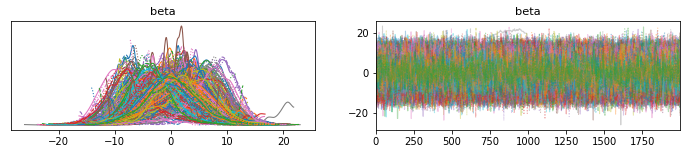

In [20]:
import arviz as az
infr_data = az.from_numpyro(mcmc_1)
az.plot_trace(infr_data, var_names=["beta"])

In [23]:
mcmc_1.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      0.23      0.42      0.00      0.00      1.00    439.32      1.00
  gamma[1]      0.33      0.47      0.00      0.00      1.00    345.29      1.01
  gamma[2]      0.19      0.39      0.00      0.00      1.00    974.53      1.00
  gamma[3]      0.24      0.43      0.00      0.00      1.00    533.24      1.00
  gamma[4]      0.26      0.44      0.00      0.00      1.00    544.75      1.01
  gamma[5]      0.23      0.42      0.00      0.00      1.00    518.00      1.00
  gamma[6]      0.33      0.47      0.00      0.00      1.00    304.23      1.01
  gamma[7]      0.41      0.49      0.00      0.00      1.00    195.97      1.01
  gamma[8]      0.21      0.40      0.00      0.00      1.00    758.64      1.00
  gamma[9]      0.18      0.38      0.00      0.00      1.00    852.78      1.01
 gamma[10]      0.23      0.42      0.00      0.00      1.00    496.85      1.01
 gamma[11]      0.19      0

In [17]:
idx_1 = jnp.squeeze(jnp.argwhere((jnp.sum(gamma_samples_1, axis=0) / 6000) > 0.3))
len(idx_1)

171

In [44]:
jnp.count_nonzero(J_1[idx_1,:][:,idx_1])

DeviceArray(42, dtype=int32)

In [18]:
get_ess(3, gamma_samples_1)

522.4616010766268

In [19]:
get_ess(3, beta_samples_1)

556.7517625362011

In [38]:
J_control = jnp.zeros((p, p))

In [49]:
kernel_2 = MixedHMC(HMC(model, target_accept_prob=0.6, step_size=1e-5), random_walk=False)
mcmc_2 = MCMC(kernel_2, num_warmup=500, num_samples=2000, 
              num_chains=3, progress_bar=True, )
mcmc_2.run(rng_key, X_train, y_train, 10.*np.identity(p), J_control, 1.0, 1.0)

/tmp/ipykernel_33/1838369654.py:2: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_2 = MCMC(kernel_2, num_warmup=500, num_samples=2000,
sample: 100%|██████████| 2500/2500 [09:26<00:00,  4.42it/s, 781 steps of size 1.63e-02. acc. prob=0.72]   


In [50]:
gamma_samples_2 = jax.device_get(mcmc_2.get_samples()["gamma"])
beta_samples_2 = jax.device_get(mcmc_2.get_samples()["beta"])

jnp.save("npy/gamma_samples_2_nb_tamox_3.npy", gamma_samples_2)
jnp.save("npy/beta_samples_2_nb_tamox_3.npy", beta_samples_2)

In [39]:
gamma_samples_2 = jnp.load("npy/gamma_samples_2_nb_tamox_3.npy")
beta_samples_2 = jnp.load("npy/beta_samples_2_nb_tamox_3.npy")

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

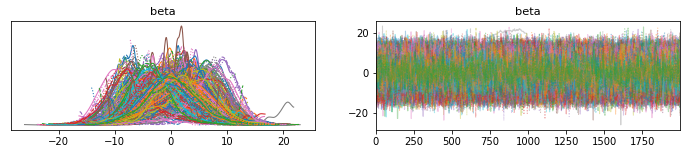

In [53]:
import arviz as az
infr_data = az.from_numpyro(mcmc_1)
az.plot_trace(infr_data, var_names=["beta"])

In [40]:
idx_2 = jnp.squeeze(jnp.argwhere((jnp.sum(gamma_samples_2, axis=0) / 6000) > 0.3))
len(idx_2)

156

In [ ]:
np.count_nonzero(J_1[idx_2,:][:,idx_2])

In [54]:
from sklearn.metrics import roc_auc_score
print(f"train auc: {roc_auc_score(y_train, logistic(X_train[:,idx_1] @ (jnp.mean(beta_samples_1[:,idx_1], axis=0))))}")
print(f"test auc: {roc_auc_score(y_test, logistic(X_test[:, idx_1] @ (jnp.mean(beta_samples_1[:, idx_1], axis=0))))}")

train auc: 0.999822695035461
test auc: 0.7245926539629935


In [52]:
print(f"train auc: {roc_auc_score(y_train, logistic(X_train[:,idx_2] @ (jnp.mean(beta_samples_1[:,idx_2], axis=0))))}")
print(f"test auc: {roc_auc_score(y_test, logistic(X_test[:, idx_2] @ (jnp.mean(beta_samples_1[:, idx_2], axis=0))))}")

train auc: 0.9979229989868288
test auc: 0.7148577740955537


In [26]:
run_fs_logreg(X_train, X_test, y_train, y_test, seed, [idx_1])

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


,log_cv_score,log_test_score
0,0.975847,0.718448


In [27]:
run_fs_logreg(X_train, X_test, y_train, y_test, seed, [idx_2])

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


,log_cv_score,log_test_score
0,0.975808,0.712787


In [28]:
run_fs_logreg(X_train, X_test, y_train, y_test, seed, [idx_sig])

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/

,log_cv_score,log_test_score
0,0.754433,0.711544


### Let's try with p val < 5% filter

In [29]:
idx_sig_2 = fisher_exact_test(X_train_df, y_train_df, 0.05)
idx_sig_2 = np.squeeze(idx_sig_2)
jnp.save("npy/idx_sig_2.npy", idx_sig_2)

Total of 1490 variables are significant (p_val = 0.05)


In [30]:
idx_sig_2 = jnp.load("npy/idx_sig_2.npy")

In [64]:
X_train_sig_2_df, X_test_sig_2_df = X_train_df.iloc[:, idx_sig_2], X_test_df.iloc[:, idx_sig_2]
X_train_sig_2_df.head()

,4111,4110,1109,2637,2642,5251,881,2886,28316,6795,...,7596,26036,57711,80095,79943,7553,7625,7637,741,23140
41,1,0,0,0,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0,0,0
585,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1
349,0,0,0,1,1,0,0,1,1,0,...,1,1,1,0,0,0,0,0,0,1
494,0,0,0,1,1,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
571,0,1,0,0,0,1,1,0,0,0,...,1,0,1,1,0,0,0,1,1,0


In [67]:
X_train_2, X_test_2 = jax.device_put(X_train_sig_2_df.to_numpy()), jax.device_put(X_test_sig_2_df.to_numpy())

In [56]:
J_2 = build_network(X_train_sig_2_df)
np.fill_diagonal(J_2, 0.)
p2 = J_2.shape[1]
jnp.save("npy/J_mat_2.npy", J_2)
np.count_nonzero(J_2)

218

In [72]:
(10.*np.identity(p2)).shape

(1490, 1490)

In [74]:
kernel_3 = MixedHMC(HMC(model, target_accept_prob=0.6, step_size=1e-5), random_walk=False)
mcmc_3 = MCMC(kernel_3, num_warmup=500, num_samples=2000,
              num_chains=3, progress_bar=True, )
mcmc_3.run(rng_key, X_train_2, y_train, 10.*np.identity(p2), J_2, 1.0, 1.0)

/tmp/ipykernel_192/907349180.py:2: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_3 = MCMC(kernel_3, num_warmup=500, num_samples=2000,
sample: 100%|██████████| 2500/2500 [40:29<00:00,  1.03it/s, 1531 steps of size 1.56e-02. acc. prob=0.54]    


In [57]:
J_control_2 = jnp.zeros((p2, p2))

In [ ]:
kernel_4 = MixedHMC(HMC(model, target_accept_prob=0.6, step_size=1e-5), random_walk=False)
mcmc_4 = MCMC(kernel_4, num_warmup=500, num_samples=2000,
              num_chains=3, progress_bar=True, )
mcmc_4.run(rng_key, X_train_2, y_train, 10.*np.identity(p2), J_control_2, 1.0, 1.0)

/tmp/ipykernel_192/2822863688.py:2: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_4 = MCMC(kernel_4, num_warmup=500, num_samples=2000,
sample:  20%|██        | 508/2500 [11:09<17:31,  1.89it/s, 1567 steps of size 1.30e-02. acc. prob=0.72]    

In [78]:
gamma_samples_3 = jax.device_get(mcmc_3.get_samples()["gamma"])
beta_samples_3 = jax.device_get(mcmc_3.get_samples()["beta"])

jnp.save("npy/gamma_samples_3_nb_tamox_3.npy", gamma_samples_3)
jnp.save("npy/beta_samples_3_nb_tamox_3.npy", beta_samples_3)

In [79]:
gamma_samples_4 = jax.device_get(mcmc_4.get_samples()["gamma"])
beta_samples_4 = jax.device_get(mcmc_4.get_samples()["beta"])

jnp.save("npy/gamma_samples_4_nb_tamox_3.npy", gamma_samples_4)
jnp.save("npy/beta_samples_4_nb_tamox_3.npy", beta_samples_4)

In [130]:
idx_3 = jnp.squeeze(jnp.argwhere((jnp.sum(gamma_samples_3, axis=0) / 6000) > 0.3))
len(idx_3)

353

In [131]:
np.count_nonzero(J_2[idx_3,:][:,idx_3])

218

In [132]:
idx_4 = jnp.squeeze(jnp.argwhere((jnp.sum(gamma_samples_4, axis=0) / 6000) > 0.3))
len(idx_4)

262

In [133]:
np.count_nonzero(J_2[idx_4,:][:,idx_4])

2

In [134]:
from sklearn.metrics import roc_auc_score
print(f"train auc: {roc_auc_score(y_train, logistic(X_train_2[:,idx_3] @ (jnp.mean(beta_samples_3[:,idx_3], axis=0))))}")
print(f"test auc: {roc_auc_score(y_test, logistic(X_test_2[:, idx_3] @ (jnp.mean(beta_samples_3[:, idx_3], axis=0))))}")

train auc: 0.9999493414387031
test auc: 0.7102319801159901


In [138]:
run_fs_logreg(X_train_2, X_test_2, y_train, y_test, seed, [idx_sig_2])

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/

,log_cv_score,log_test_score
0,0.764903,0.736123


In [139]:
run_fs_logreg(X_train_2, X_test_2, y_train, y_test, seed, [idx_3])

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


,log_cv_score,log_test_score
0,0.984553,0.70464


In [140]:
run_fs_logreg(X_train_2, X_test_2, y_train, y_test, seed, [idx_4])

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


,log_cv_score,log_test_score
0,0.988594,0.705606


### Runs with different seeds with and without background knowledge

In [15]:
thresholds = np.arange(0.1, 1.0, 0.1)

In [16]:
import logging
import sys
import warnings
warnings.filterwarnings("ignore")

def prepare_data(seed, X, y, p_val=0.01):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=seed)

    idx_sig = np.squeeze(fisher_exact_test(X_train, y_train, p_val))
    X_train_sig, X_test_sig = X_train.iloc[:,idx_sig], X_test.iloc[:,idx_sig]

    jnp.save(f"exp_data/npy/idx_sig_s_{seed}.npy", idx_sig)

    return X_train_sig, X_test_sig, y_train, y_test

def setup_logger(seed):
    logging.getLogger().handlers = []
    logging.getLogger().setLevel(logging.NOTSET)

    formatter = logging.Formatter("%(asctime)s [%(levelname)s], %(message)s")

    console = logging.StreamHandler(sys.stdout)
    console.setLevel(logging.INFO)
    console.setFormatter(formatter)
    logging.getLogger().addHandler(console)

    rotatingHandler = logging.handlers.RotatingFileHandler(filename=f"exp_data/logs/log_s_{seed}.log", maxBytes=(1048576*5),
                                                           backupCount=7)
    rotatingHandler.setLevel(logging.INFO)
    rotatingHandler.setFormatter(formatter)
    logging.getLogger().addHandler(rotatingHandler)
    log = logging.getLogger()
    return log

def gamma_energy(gamma, J, eta, mu):
    return eta*jnp.dot(jnp.dot(gamma.T, J), gamma) - mu*jnp.sum(gamma)

def model(X, y, sigma, J, eta=1.0, mu=1.0):
    p = X.shape[1]
    L = np.linalg.cholesky(sigma)
    z = npyro.sample('z', dist.Normal(np.zeros(p), 1))
    beta = npyro.deterministic('beta', L @ z)
    # beta = npyro.sample('beta', dist.MultivariateNormal(0, sigma))
    gamma = npyro.sample('gamma', dist.Bernoulli(0.5*jnp.ones(p)))
    npyro.factor('gamma_lgp', gamma_energy(gamma, J, eta, mu))
    logits = npyro.deterministic("logits", jnp.dot(X, (beta*gamma)))
    # print(f"Probs: {logits.shape}")
    likelihood = npyro.sample("y", dist.Bernoulli(logits=logits),
                              obs=y)

In [17]:

def run_exp(X, y, seeds, jax_seeds):

    num_warmup = 500
    num_samples = 3000
    num_chains = 3

    for i, seed in enumerate(seeds):
        np.random.seed(seed)
        log = setup_logger(seed)
        log.info(f"========= Running seed - {seed} =========")
        X_train_sig, X_test_sig, y_train, y_test = prepare_data(seed, X, y)
        J = build_network(X_train_sig)
        p = J.shape[1]
        np.fill_diagonal(J, 0.)
        J_control = np.zeros((p, p))
        log.info(f"Num of sig feats - {p}")
        rng_key = jax_seeds[i]

        X_train, X_test = jax.device_put(X_train_sig.to_numpy()), jax.device_put(X_test_sig.to_numpy())
        y_train, y_test = jax.device_put(y_train.to_numpy()), jax.device_put(y_test.to_numpy())

        # # Run exp with background graph
        kernel_1 = MixedHMC(HMC(model, target_accept_prob=0.6, step_size=1e-5), random_walk=False)
        mcmc_1 = MCMC(kernel_1, num_warmup=num_warmup, num_samples=num_samples,
                      num_chains=num_chains, progress_bar=False)
        mcmc_1.run(rng_key, X_train, y_train, 10.*np.identity(p), J, 1.0, 1.0)

        # Run without background graph
        kernel_2 = MixedHMC(HMC(model, target_accept_prob=0.6, step_size=1e-5), random_walk=False)
        mcmc_2 = MCMC(kernel_2, num_warmup=num_warmup, num_samples=num_samples,
                      num_chains=num_chains, progress_bar=False)

        mcmc_2.run(rng_key, X_train, y_train, 10.*np.identity(p), J_control, 1.0, 1.0)


        gamma_samples_1 = jax.device_get(mcmc_1.get_samples()["gamma"])
        beta_samples_1 = jax.device_get(mcmc_1.get_samples()["beta"])
        gamma_samples_2 = jax.device_get(mcmc_2.get_samples()["gamma"])
        beta_samples_2 = jax.device_get(mcmc_2.get_samples()["beta"])

        jnp.save(f"exp_data/npy/gamma_samples_1_s_{seed}.npy", gamma_samples_1)
        jnp.save(f"exp_data/npy/beta_samples_1_s_{seed}.npy", beta_samples_1)

        jnp.save(f"exp_data/npy/gamma_samples_2_s_{seed}.npy", gamma_samples_2)
        jnp.save(f"exp_data/npy/beta_samples_2_s_{seed}.npy", beta_samples_2)


        jnp.save(f"exp_data/npy/J_mat_s_{seed}.npy", J)


        gamma_ess_1 = get_ess(num_chains, gamma_samples_1)
        beta_ess_1 = get_ess(num_chains, beta_samples_1)
        gamma_ess_2 = get_ess(num_chains, gamma_samples_2)
        beta_ess_2 = get_ess(num_chains, beta_samples_2)

        log.info(f"MCMC 1 ess stats: gamma ess - {gamma_ess_1}, beta ess - {beta_ess_1}")
        log.info(f"MCMC 2 ess stats: gamma ess - {gamma_ess_2}, beta ess - {beta_ess_2}")

        N = num_chains * num_samples

        res_bkg_ls = []
        res_no_bkg_ls = []

        res_beta_bkg_ls = []
        res_beta_no_bkg_ls = []

        for t in thresholds:
            idx_1 = jnp.squeeze(jnp.argwhere((jnp.sum(gamma_samples_1, axis=0) / N) > t))
            idx_2 = jnp.squeeze(jnp.argwhere((jnp.sum(gamma_samples_2, axis=0) / N) > t))

            num_edges_1 = jnp.count_nonzero(J[idx_1,:][:,idx_1]) if idx_1.size > 1 else 0
            num_edges_2 = jnp.count_nonzero(J[idx_2,:][:,idx_2]) if idx_2.size > 1 else 0

            log.info(f"thresh - {t:.2f}, length idx_1: {idx_1.size}, length idx_2: {idx_2.size}, | num in J idx_1: {num_edges_1}, "
                          f"num in J idx_2: {num_edges_2}")

            res_idx_1_df = run_fs_logreg(X_train, X_test, y_train, y_test, [idx_1])
            res_idx_2_df = run_fs_logreg(X_train, X_test, y_train, y_test, [idx_2])

            res_bkg_ls.append(res_idx_1_df)
            res_no_bkg_ls.append(res_idx_2_df)

            beta_sel_1 = jnp.mean(beta_samples_1[:,idx_1], axis=0)
            beta_sel_2 = jnp.mean(beta_samples_2[:,idx_2], axis=0)
            result_beta_1 = {"train_auc_score": [], "test_auc_score": []}
            result_beta_2 = {"train_auc_score": [], "test_auc_score": []}

            if idx_1.size == 1:
                beta_sel_1 = beta_sel_1.reshape(-1, 1)
                X_train_idx_1_sel = X_train[:,idx_1].reshape(-1, 1)
                X_test_idx_1_sel = X_test[:,idx_1].reshape(-1, 1)

            else:
                X_train_idx_1_sel = X_train[:,idx_1]
                X_test_idx_1_sel = X_test[:,idx_1]

            if idx_2.size == 1:
                beta_sel_2 = beta_sel_2.reshape(-1, 1)
                X_train_idx_2_sel = X_train[:,idx_2].reshape(-1, 1)
                X_test_idx_2_sel = X_test[:,idx_2].reshape(-1, 1)

            else:
                X_train_idx_2_sel = X_train[:,idx_2]
                X_test_idx_2_sel = X_test[:,idx_2]

            train_roc_1 = roc_auc_score(y_train, logistic((X_train_idx_1_sel @ beta_sel_1)))
            test_roc_1 = roc_auc_score(y_test, logistic((X_test_idx_1_sel @ beta_sel_1)))
            result_beta_1["train_auc_score"].append(train_roc_1)
            result_beta_1["test_auc_score"].append(test_roc_1)

            train_roc_2 = roc_auc_score(y_train, logistic((X_train_idx_2_sel @ beta_sel_2)))
            test_roc_2 = roc_auc_score(y_test, logistic((X_test_idx_2_sel @ beta_sel_2)))
            result_beta_2["train_auc_score"].append(train_roc_2)
            result_beta_2["test_auc_score"].append(test_roc_2)

            log.info(f"thresh - {t:.2f}, beta_1 train auc: {train_roc_1:.2f}, beta_1 test auc: {test_roc_1:.2f} "
                          f"| beta_2 train auc: {train_roc_2:.2f}, beta_2 test auc: {test_roc_2:.2f}")

            res_beta_1_df = pd.DataFrame(result_beta_1)
            res_beta_2_df = pd.DataFrame(result_beta_2)

            res_beta_bkg_ls.append(res_beta_1_df)
            res_beta_no_bkg_ls.append(res_beta_2_df)

        res_bkg_df = pd.concat(res_bkg_ls, axis=0)
        res_no_bkg_df = pd.concat(res_no_bkg_ls, axis=0)

        res_bkg_df["thres"] = thresholds
        res_no_bkg_df["thres"] = thresholds

        res_bkg_df.to_csv(f"exp_data/res_bkg_s_{seed}.csv", index=False)
        res_no_bkg_df.to_csv(f"exp_data/res_no_bkg_s_{seed}.csv", index=False)

        res_beta_bkg_df = pd.concat(res_beta_bkg_ls, axis=0)
        res_beta_no_bkg_df = pd.concat(res_beta_no_bkg_ls, axis=0)
        res_beta_bkg_df["thres"] = thresholds
        res_beta_no_bkg_df["thres"] = thresholds

        res_beta_bkg_df.to_csv(f"exp_data/res_beta_bkg_s_{seed}.csv", index=False)
        res_beta_no_bkg_df.to_csv(f"exp_data/res_beta_no_bkg_s_{seed}.csv", index=False)

        log.info(f"========= Done for seed - {seed} =========")

In [23]:
k = 47
print(exp_seeds[k:])

[506, 805, 490]


In [19]:
# Feat 97 and 950 for consideration
curr_seeds = exp_seeds[k:]
curr_jax_seeds = jax_exp_seeds[k:]

In [ ]:
# run_exp(X_df, y_df, curr_seeds, curr_jax_seeds)

2022-08-17 16:31:42,344 [INFO], ========= Running seed - 499 =========
Total of 508 variables are significant (p_val = 0.01)
2022-08-17 16:32:45,881 [INFO], Num of sig feats - 508
2022-08-17 18:32:47,779 [INFO], MCMC 1 ess stats: gamma ess - 869.1396359493282, beta ess - 955.1840538905986
2022-08-17 18:32:47,780 [INFO], MCMC 2 ess stats: gamma ess - 837.6849810042488, beta ess - 816.7707645822638
2022-08-17 18:32:48,939 [INFO], thresh - 0.10, length idx_1: 508, length idx_2: 508, | num in J idx_1: 44, num in J idx_2: 44


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


2022-08-17 18:32:51,338 [INFO], thresh - 0.10, beta_1 train auc: 1.00, beta_1 test auc: 0.66 | beta_2 train auc: 1.00, beta_2 test auc: 0.67
2022-08-17 18:32:52,291 [INFO], thresh - 0.20, length idx_1: 325, length idx_2: 303, | num in J idx_1: 44, num in J idx_2: 8


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


2022-08-17 18:32:54,160 [INFO], thresh - 0.20, beta_1 train auc: 1.00, beta_1 test auc: 0.66 | beta_2 train auc: 1.00, beta_2 test auc: 0.66
2022-08-17 18:32:55,107 [INFO], thresh - 0.30, length idx_1: 155, length idx_2: 140, | num in J idx_1: 44, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


2022-08-17 18:32:56,858 [INFO], thresh - 0.30, beta_1 train auc: 1.00, beta_1 test auc: 0.66 | beta_2 train auc: 1.00, beta_2 test auc: 0.68
2022-08-17 18:32:57,774 [INFO], thresh - 0.40, length idx_1: 97, length idx_2: 74, | num in J idx_1: 42, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


2022-08-17 18:32:59,547 [INFO], thresh - 0.40, beta_1 train auc: 0.98, beta_1 test auc: 0.62 | beta_2 train auc: 0.97, beta_2 test auc: 0.64
2022-08-17 18:33:00,479 [INFO], thresh - 0.50, length idx_1: 64, length idx_2: 51, | num in J idx_1: 40, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


2022-08-17 18:33:02,330 [INFO], thresh - 0.50, beta_1 train auc: 0.94, beta_1 test auc: 0.64 | beta_2 train auc: 0.94, beta_2 test auc: 0.62
2022-08-17 18:33:03,225 [INFO], thresh - 0.60, length idx_1: 40, length idx_2: 25, | num in J idx_1: 34, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


2022-08-17 18:33:04,945 [INFO], thresh - 0.60, beta_1 train auc: 0.91, beta_1 test auc: 0.60 | beta_2 train auc: 0.89, beta_2 test auc: 0.64
2022-08-17 18:33:05,822 [INFO], thresh - 0.70, length idx_1: 28, length idx_2: 19, | num in J idx_1: 20, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


2022-08-17 18:33:07,505 [INFO], thresh - 0.70, beta_1 train auc: 0.83, beta_1 test auc: 0.55 | beta_2 train auc: 0.87, beta_2 test auc: 0.61
2022-08-17 18:33:08,356 [INFO], thresh - 0.80, length idx_1: 21, length idx_2: 14, | num in J idx_1: 10, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


2022-08-17 18:33:09,959 [INFO], thresh - 0.80, beta_1 train auc: 0.79, beta_1 test auc: 0.56 | beta_2 train auc: 0.78, beta_2 test auc: 0.54
2022-08-17 18:33:10,791 [INFO], thresh - 0.90, length idx_1: 11, length idx_2: 6, | num in J idx_1: 4, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


2022-08-17 18:33:12,410 [INFO], thresh - 0.90, beta_1 train auc: 0.76, beta_1 test auc: 0.60 | beta_2 train auc: 0.71, beta_2 test auc: 0.53
2022-08-17 18:33:12,726 [INFO], ========= Done for seed - 499 =========
2022-08-17 18:33:12,729 [INFO], ========= Running seed - 925 =========
Total of 586 variables are significant (p_val = 0.01)
2022-08-17 18:34:16,229 [INFO], Num of sig feats - 586
2022-08-17 21:51:59,271 [INFO], MCMC 1 ess stats: gamma ess - 1101.629016011779, beta ess - 997.3061518693854
2022-08-17 21:51:59,272 [INFO], MCMC 2 ess stats: gamma ess - 1023.2533172252427, beta ess - 816.5177993062318
2022-08-17 21:52:00,410 [INFO], thresh - 0.10, length idx_1: 586, length idx_2: 586, | num in J idx_1: 46, num in J idx_2: 46


100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


2022-08-17 21:52:01,339 [INFO], thresh - 0.10, beta_1 train auc: 1.00, beta_1 test auc: 0.69 | beta_2 train auc: 1.00, beta_2 test auc: 0.69
2022-08-17 21:52:02,325 [INFO], thresh - 0.20, length idx_1: 457, length idx_2: 432, | num in J idx_1: 46, num in J idx_2: 30


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


2022-08-17 21:52:04,219 [INFO], thresh - 0.20, beta_1 train auc: 1.00, beta_1 test auc: 0.69 | beta_2 train auc: 1.00, beta_2 test auc: 0.69
2022-08-17 21:52:04,785 [INFO], thresh - 0.30, length idx_1: 164, length idx_2: 140, | num in J idx_1: 46, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


2022-08-17 21:52:06,002 [INFO], thresh - 0.30, beta_1 train auc: 1.00, beta_1 test auc: 0.70 | beta_2 train auc: 1.00, beta_2 test auc: 0.69
2022-08-17 21:52:06,938 [INFO], thresh - 0.40, length idx_1: 92, length idx_2: 71, | num in J idx_1: 36, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


2022-08-17 21:52:08,752 [INFO], thresh - 0.40, beta_1 train auc: 0.99, beta_1 test auc: 0.68 | beta_2 train auc: 0.99, beta_2 test auc: 0.68
2022-08-17 21:52:09,684 [INFO], thresh - 0.50, length idx_1: 60, length idx_2: 50, | num in J idx_1: 32, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


2022-08-17 21:52:11,422 [INFO], thresh - 0.50, beta_1 train auc: 0.98, beta_1 test auc: 0.67 | beta_2 train auc: 0.98, beta_2 test auc: 0.68
2022-08-17 21:52:12,312 [INFO], thresh - 0.60, length idx_1: 47, length idx_2: 29, | num in J idx_1: 32, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


2022-08-17 21:52:14,085 [INFO], thresh - 0.60, beta_1 train auc: 0.95, beta_1 test auc: 0.67 | beta_2 train auc: 0.93, beta_2 test auc: 0.67
2022-08-17 21:52:14,605 [INFO], thresh - 0.70, length idx_1: 28, length idx_2: 20, | num in J idx_1: 20, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


2022-08-17 21:52:15,633 [INFO], thresh - 0.70, beta_1 train auc: 0.87, beta_1 test auc: 0.64 | beta_2 train auc: 0.89, beta_2 test auc: 0.66
2022-08-17 21:52:16,471 [INFO], thresh - 0.80, length idx_1: 13, length idx_2: 9, | num in J idx_1: 8, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


2022-08-17 21:52:18,096 [INFO], thresh - 0.80, beta_1 train auc: 0.82, beta_1 test auc: 0.62 | beta_2 train auc: 0.81, beta_2 test auc: 0.66
2022-08-17 21:52:18,926 [INFO], thresh - 0.90, length idx_1: 7, length idx_2: 3, | num in J idx_1: 6, num in J idx_2: 0


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


2022-08-17 21:52:20,538 [INFO], thresh - 0.90, beta_1 train auc: 0.73, beta_1 test auc: 0.57 | beta_2 train auc: 0.66, beta_2 test auc: 0.53
2022-08-17 21:52:20,955 [INFO], ========= Done for seed - 925 =========
2022-08-17 21:52:20,957 [INFO], ========= Running seed - 506 =========
Total of 788 variables are significant (p_val = 0.01)
2022-08-17 21:53:25,929 [INFO], Num of sig feats - 788


In [24]:
fseeds = exp_seeds[:k]
len(fseeds)

47

In [25]:
with open("exp_data/logs/log_s_440.log", "r") as fp:
    log_lines = fp.readlines()

In [26]:
res_bkg_dfs = []
res_no_bkg_dfs = []
for i, fseed in enumerate(fseeds):

    if fseed == 97 or fseed == 950: ## the experiment for seed 97 & 950 doesn't show up for some reason!!
        continue

    bkg_df = pd.read_csv(f"exp_data/res_bkg_s_{fseed}.csv")
    no_bkg_df = pd.read_csv(f"exp_data/res_no_bkg_s_{fseed}.csv")

    seed_col = [fseed]*len(thresholds)

    bkg_df["seed"] = seed_col
    no_bkg_df["seed"] = seed_col

    bkg_num_sel, no_bkg_num_sel = [], []
    bkg_num_j, no_bkg_num_j = [], []

    with open(f"exp_data/logs/log_s_{fseed}.log", "r") as fp:
        log_lines = fp.readlines()

    log_lines = log_lines[4:-1:2]
    for j, thr in enumerate(thresholds):
        line = log_lines[j].strip().split(",")
        num_bkg =  int(line[3].split(":")[-1])
        num_no_bkg = int(line[4].split(":")[-1])

        bkg_num_sel.append(num_bkg)
        no_bkg_num_sel.append(num_no_bkg)

        num_j_bkg = int(line[5].split(":")[-1])
        num_j_no_bkg = int(line[6].split(":")[-1])
        bkg_num_j.append(num_j_bkg)
        no_bkg_num_j.append(num_j_no_bkg)


    bkg_df["num_sel"] = bkg_num_sel
    bkg_df["num_in_J"] = bkg_num_j

    no_bkg_df["num_sel"] = no_bkg_num_sel
    no_bkg_df["num_in_J"] = no_bkg_num_j

    res_bkg_dfs.append(bkg_df)
    res_no_bkg_dfs.append(no_bkg_df)


In [27]:
bkg_res_df = pd.concat(res_bkg_dfs, axis=0)
no_bkg_res_df = pd.concat(res_no_bkg_dfs, axis=0)

In [28]:
bkg_res_df["thres"] = np.round(bkg_res_df["thres"], 1)
no_bkg_res_df["thres"] = np.round(no_bkg_res_df["thres"], 1)

In [29]:
bkg_res_df

,log_cv_score,log_test_score,thres,seed,num_sel,num_in_J
0,0.716300,0.746203,0.1,61,518,14
1,0.871894,0.750069,0.2,61,313,14
2,0.937655,0.772991,0.3,61,153,14
3,0.941064,0.738884,0.4,61,88,12
4,0.908440,0.731842,0.5,61,54,8
...,...,...,...,...,...,...
4,0.947817,0.705054,0.5,925,60,32
5,0.927931,0.674952,0.6,925,47,32
6,0.878669,0.694421,0.7,925,28,20
7,0.816124,0.660867,0.8,925,13,8


In [30]:
no_bkg_res_df

,log_cv_score,log_test_score,thres,seed,num_sel,num_in_J
0,0.716300,0.746203,0.1,61,518,14
1,0.878617,0.740541,0.2,61,305,6
2,0.944658,0.782104,0.3,61,144,4
3,0.949120,0.737918,0.4,61,81,0
4,0.926544,0.752693,0.5,61,51,0
...,...,...,...,...,...,...
4,0.954011,0.705330,0.5,925,50,0
5,0.921111,0.685032,0.6,925,29,0
6,0.890954,0.670533,0.7,925,20,0
7,0.807060,0.679577,0.8,925,9,0


### Two-sided t-test

In [31]:
import scipy.stats as stats

p_vals_ts_train = np.zeros(len(thresholds))
p_vals_ts_test = np.zeros(len(thresholds))

for i, thr in enumerate(thresholds):
    thr = np.round(thr, 1)
    thr_bkg = bkg_res_df[bkg_res_df["thres"] == thr]
    thr_bkg_tr = thr_bkg["log_cv_score"]
    thr_bkg_te = thr_bkg["log_test_score"]

    thr_no_bkg = no_bkg_res_df[no_bkg_res_df["thres"] == thr]
    thr_no_bkg_tr = thr_no_bkg["log_cv_score"]
    thr_no_bkg_te = thr_no_bkg["log_test_score"]
    p_val_tr = stats.ttest_rel(thr_bkg_tr, thr_no_bkg_tr, alternative="two-sided").pvalue
    p_val_te = stats.ttest_rel(thr_bkg_te, thr_no_bkg_te, alternative="two-sided").pvalue
    p_vals_ts_train[i] = p_val_tr
    p_vals_ts_test[i] = p_val_te
    print(f"thr: {thr}, p_val_tr: {p_val_tr}, p_val_te: {p_val_te}")


thr: 0.1, p_val_tr: 0.3227784787543093, p_val_te: 0.3227784787543093
thr: 0.2, p_val_tr: 1.3540007985937043e-13, p_val_te: 0.0010378368139106538
thr: 0.3, p_val_tr: 1.0711735123731131e-11, p_val_te: 0.12796742275762468
thr: 0.4, p_val_tr: 5.4038228206254895e-08, p_val_te: 0.5953317215160199
thr: 0.5, p_val_tr: 1.67029478645793e-06, p_val_te: 0.7813465886570665
thr: 0.6, p_val_tr: 0.24821035832519028, p_val_te: 0.22267870407765683
thr: 0.7, p_val_tr: 5.111392152993329e-05, p_val_te: 1.7329448201909024e-05
thr: 0.8, p_val_tr: 5.255912385581498e-05, p_val_te: 0.00012764733024855113
thr: 0.9, p_val_tr: 1.4608961016509855e-07, p_val_te: 0.00016667027162944707


### One sided t-test

In [32]:
p_vals_os_train = np.zeros(len(thresholds))
p_vals_os_test = np.zeros(len(thresholds))

for i, thr in enumerate(thresholds):
    thr = np.round(thr, 1)
    thr_bkg = bkg_res_df[bkg_res_df["thres"] == thr]
    thr_bkg_tr = thr_bkg["log_cv_score"]
    thr_bkg_te = thr_bkg["log_test_score"]

    thr_no_bkg = no_bkg_res_df[no_bkg_res_df["thres"] == thr]
    thr_no_bkg_tr = thr_no_bkg["log_cv_score"]
    thr_no_bkg_te = thr_no_bkg["log_test_score"]
    p_val_tr = stats.ttest_rel(thr_bkg_tr, thr_no_bkg_tr, alternative="greater").pvalue
    p_val_te = stats.ttest_rel(thr_bkg_te, thr_no_bkg_te, alternative="greater").pvalue
    p_vals_os_train[i] = p_val_tr
    p_vals_os_test[i] = p_val_te
    print(f"thr: {thr}, p_val_tr: {p_val_tr}, p_val_te: {p_val_te}")

thr: 0.1, p_val_tr: 0.8386107606228453, p_val_te: 0.16138923937715466
thr: 0.2, p_val_tr: 0.9999999999999323, p_val_te: 0.0005189184069553269
thr: 0.3, p_val_tr: 0.9999999999946442, p_val_te: 0.9360162886211877
thr: 0.4, p_val_tr: 0.9999999729808858, p_val_te: 0.29766586075800994
thr: 0.5, p_val_tr: 0.9999991648526068, p_val_te: 0.6093267056714667
thr: 0.6, p_val_tr: 0.8758948208374049, p_val_te: 0.11133935203882842
thr: 0.7, p_val_tr: 2.5556960764966646e-05, p_val_te: 8.664724100954512e-06
thr: 0.8, p_val_tr: 2.627956192790749e-05, p_val_te: 6.382366512427556e-05
thr: 0.9, p_val_tr: 7.304480508254927e-08, p_val_te: 8.333513581472354e-05


In [33]:
thr_num_sel_bkg = np.zeros((len(thresholds), len(fseeds) - 2), dtype=np.int) # subtract one b/c of seed 97 and 950
thr_num_sel_no_bkg = np.zeros((len(thresholds), len(fseeds) - 2), dtype=np.int)

thr_num_sel_J_bkg = np.zeros((len(thresholds), len(fseeds) - 2), dtype=np.int)
thr_num_sel_J_no_bkg = np.zeros((len(thresholds), len(fseeds) - 2), dtype=np.int)

thr_train_score_bkg = np.zeros((len(thresholds), len(fseeds) - 2))
thr_test_score_bkg = np.zeros((len(thresholds), len(fseeds) - 2))

thr_train_score_no_bkg = np.zeros((len(thresholds), len(fseeds) - 2))
thr_test_score_no_bkg = np.zeros((len(thresholds), len(fseeds) - 2))

for i, thr in enumerate(thresholds):
    thr = np.round(thr, 1)
    thr_bkg = bkg_res_df[bkg_res_df["thres"] == thr]
    thr_num_sel_bkg[i] = np.squeeze(thr_bkg["num_sel"].to_numpy())
    thr_num_sel_J_bkg[i] = np.squeeze(thr_bkg["num_in_J"].to_numpy())
    thr_train_score_bkg[i] = np.squeeze(thr_bkg["log_cv_score"].to_numpy())
    thr_test_score_bkg[i] = np.squeeze(thr_bkg["log_test_score"].to_numpy())

    thr_no_bkg = no_bkg_res_df[no_bkg_res_df["thres"] == thr]
    thr_num_sel_no_bkg[i] = np.squeeze(thr_no_bkg["num_sel"].to_numpy())
    thr_num_sel_J_no_bkg[i] = np.squeeze(thr_no_bkg["num_in_J"].to_numpy())
    thr_train_score_no_bkg[i] = np.squeeze(thr_no_bkg["log_cv_score"].to_numpy())
    thr_test_score_no_bkg[i] = np.squeeze(thr_no_bkg["log_test_score"].to_numpy())

In [34]:
thr_num_sel_bkg_mean = np.mean(thr_num_sel_bkg, axis=1)
thr_num_sel_no_bkg_mean = np.mean(thr_num_sel_no_bkg, axis=1)

thr_num_sel_J_bkg_mean = np.mean(thr_num_sel_J_bkg, axis=1)
thr_num_sel_J_no_bkg_mean = np.mean(thr_num_sel_J_no_bkg, axis=1)

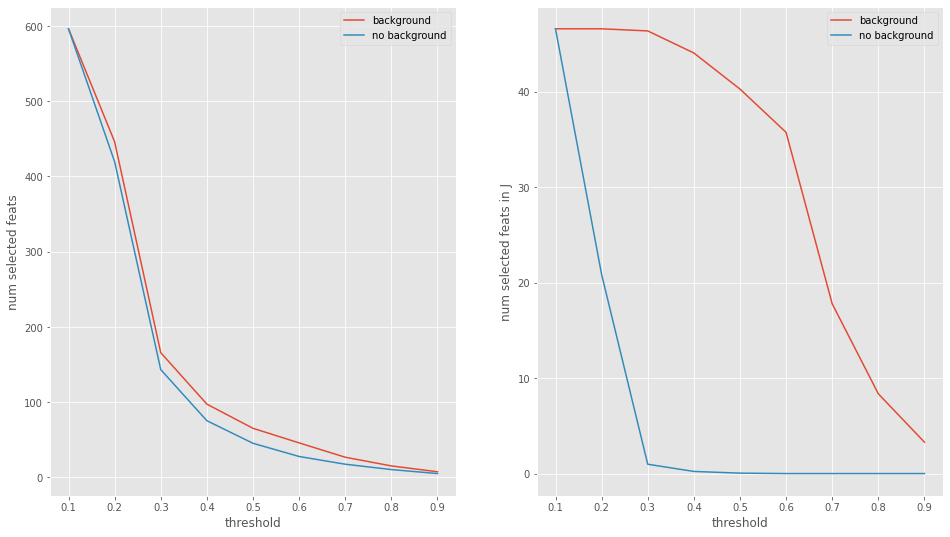

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))

axs[0].plot(thresholds, thr_num_sel_bkg_mean, label="background")
axs[0].plot(thresholds, thr_num_sel_no_bkg_mean, label="no background")
axs[0].set_xlabel("threshold")
axs[0].set_ylabel("num selected feats")
axs[0].legend()

axs[1].plot(thresholds, thr_num_sel_J_bkg_mean, label="background")
axs[1].plot(thresholds, thr_num_sel_J_no_bkg_mean, label="no background")
axs[1].set_xlabel("threshold")
axs[1].set_ylabel("num selected feats in J")
axs[1].legend()

In [36]:
thr_train_sc_bkg_mean = np.mean(thr_train_score_bkg, axis=1)
thr_test_sc_bkg_mean = np.mean(thr_test_score_bkg, axis=1)

thr_train_sc_no_bkg_mean = np.mean(thr_train_score_no_bkg, axis=1)
thr_test_sc_no_bkg_mean = np.mean(thr_test_score_no_bkg, axis=1)

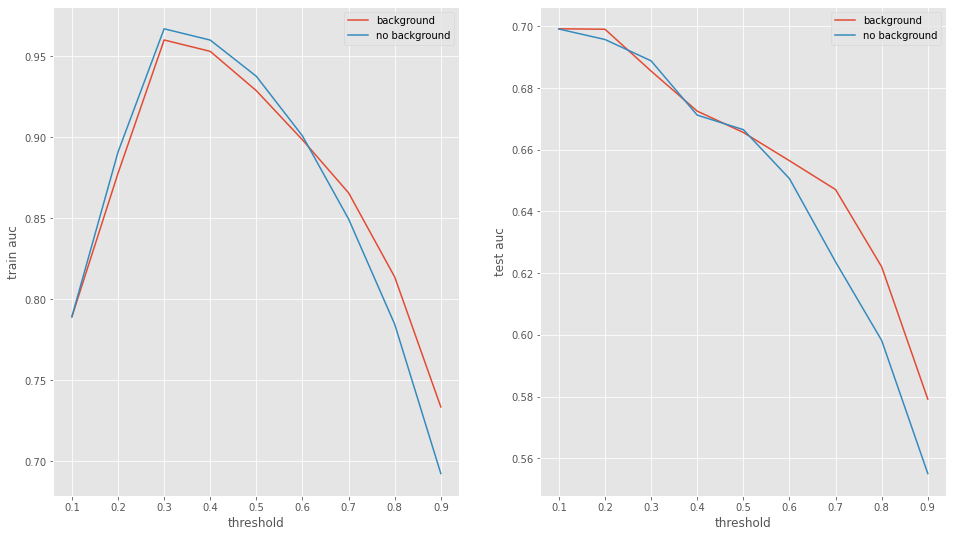

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))

axs[0].plot(thresholds, thr_train_sc_bkg_mean, label="background")
axs[0].plot(thresholds, thr_train_sc_no_bkg_mean, label="no background")
axs[0].set_xlabel("threshold")
axs[0].set_ylabel("train auc")
axs[0].legend()

axs[1].plot(thresholds, thr_test_sc_bkg_mean, label="background")
axs[1].plot(thresholds, thr_test_sc_no_bkg_mean, label="no background")
axs[1].set_xlabel("threshold")
axs[1].set_ylabel("test auc")
axs[1].legend()

In [ ]:
thr_num_sel_J_bkg_mean